In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


In [2]:
import pandas as pd

# Load the provided datasets
customers_path = r'C:\Users\akash\Downloads\Customers.csv'
transactions_path = r'C:\Users\akash\Downloads\Transactions.csv'
products_path = r'C:\Users\akash\Downloads\Products.csv'

customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)
products_df = pd.read_csv(products_path)

# Display the first few rows of each dataset to understand their structure
customers_head = customers_df.head()
transactions_head = transactions_df.head()
products_head = products_df.head()

customers_head, transactions_head, products_head


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  ,
   ProductID              ProductName     Catego

# Clustering:
Use features derived from customer profiles and transactions for clustering.
Normalize the data before applying clustering algorithms.

In [3]:
# Merge transactions with products to include product details
transactions_products = transactions_df.merge(products_df, on="ProductID", how="left")

# Merge the result with customers to include customer details
merged_data = transactions_products.merge(customers_df, on="CustomerID", how="left")

# Aggregate data for each customer to derive features for clustering
customer_features = merged_data.groupby("CustomerID").agg(
    TotalSpending=("TotalValue", "sum"),
    TotalTransactions=("TransactionID", "nunique"),
    AvgTransactionValue=("TotalValue", "mean"),
    TotalQuantity=("Quantity", "sum"),
    UniqueCategories=("Category", "nunique"),
    Region=("Region", "first"),
    SignupDate=("SignupDate", "first"),
).reset_index()

# Convert SignupDate to datetime and calculate the time since signup
customer_features["SignupDate"] = pd.to_datetime(customer_features["SignupDate"])
customer_features["DaysSinceSignup"] = (pd.Timestamp.now() - customer_features["SignupDate"]).dt.days

# Drop columns not needed for clustering
customer_features_clustering = customer_features.drop(columns=["CustomerID", "SignupDate", "Region"])

# Check the prepared features
customer_features_clustering.head()


,TotalSpending,TotalTransactions,AvgTransactionValue,TotalQuantity,UniqueCategories,DaysSinceSignup
0,3354.52,5,670.904,12,3,932
1,1862.74,4,465.685,10,2,1079
2,2725.38,4,681.345,14,3,326
3,5354.88,8,669.360,23,3,841
4,2034.24,3,678.080,7,2,896


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features_clustering)

# Perform KMeans clustering with a range of cluster numbers (2 to 10) to find the best DB Index
best_db_index = float("inf")
best_k = None
best_model = None

for k in range(2, 11):  # Testing clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(normalized_features)
    db_index = davies_bouldin_score(normalized_features, labels)
    
    if db_index < best_db_index:
        best_db_index = db_index
        best_k = k
        best_model = kmeans

# Store the best results
best_labels = best_model.labels_
best_k, best_db_index


(9, 1.1566801603960046)

# vistulizing
Use dimensionality reduction techniques (e.g., PCA or t-SNE) for a 2D plot.


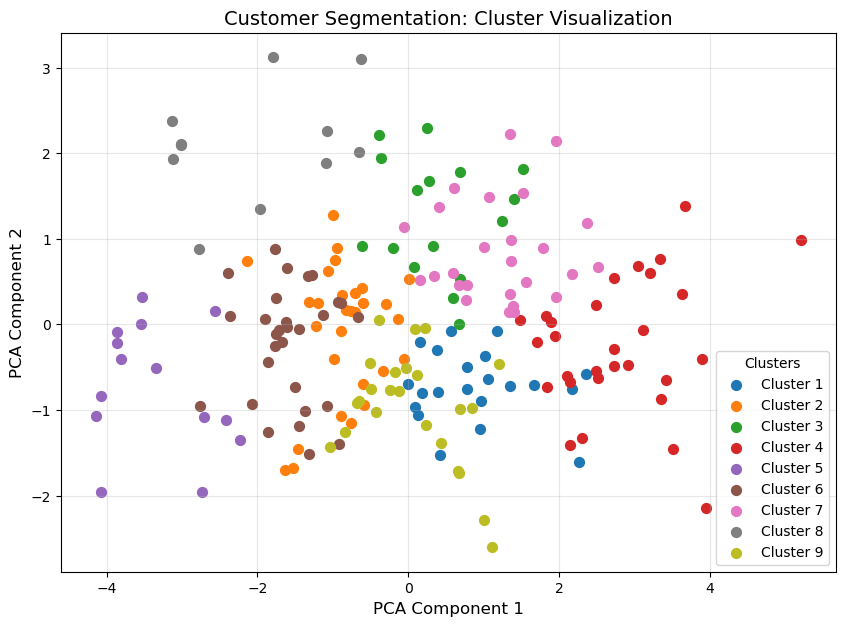

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(normalized_features)

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster_id in range(best_k):
    cluster_points = reduced_features[best_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", s=50)

plt.title("Customer Segmentation: Cluster Visualization", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend(title="Clusters", fontsize=10)
plt.grid(alpha=0.3)
plt.show()


In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Filter for the first 20 customers
target_customers = customer_features[customer_features["CustomerID"].str.startswith("C00")].head(20)

# Prepare data for similarity computation (normalize and encode relevant columns)
profile_features = customer_features.drop(columns=["CustomerID", "SignupDate", "Region"])
normalized_profiles = scaler.fit_transform(profile_features)

# Compute pairwise cosine similarity
similarity_matrix = cosine_similarity(normalized_profiles)

# Create a map for the top 3 lookalikes for each target customer
lookalike_map = {}

for idx, customer_id in enumerate(target_customers["CustomerID"]):
    # Get similarity scores for the current customer and sort them in descending order
    similarity_scores = list(enumerate(similarity_matrix[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top 3 similar customers (excluding the customer itself)
    top_3_similar = [
        (target_customers.iloc[i[0]]["CustomerID"], round(i[1], 3))
        for i in similarity_scores[1:4]
    ]
    
    # Update the lookalike map
    lookalike_map[customer_id] = top_3_similar

# Convert the lookalike map to a DataFrame for export
lookalike_df = pd.DataFrame({
    "cust_id": lookalike_map.keys(),
    "List<cust_id,score>": lookalike_map.values()
})

# Save the lookalike map to a CSV file
output_path = "/mnt/data/Lookalike.csv"
lookalike_df.to_csv(output_path, index=False)

output_path


IndexError: single positional indexer is out-of-bounds